In [1]:
import pandas as pd
df = pd.read_csv('/content/segmented_trajectories.csv')
df.head()

,BaseDateTime,LAT,LON,MMSI,PatternDescriptor,Pattern_High Speed,Pattern_Slow Movement,Pattern_Stationary,SOG,SegmentID
0,2022-03-31 00:00:17,26.11809,-80.148150,1056261,Stationary,NaN,NaN,1.0,0.100000,0
1,2022-03-31 00:00:27,26.11809,-80.148148,1056261,Stationary,NaN,NaN,1.0,0.083607,0
2,2022-03-31 00:00:37,26.11809,-80.148147,1056261,Stationary,NaN,NaN,1.0,0.067213,0
3,2022-03-31 00:00:47,26.11809,-80.148145,1056261,Stationary,NaN,NaN,1.0,0.050820,0
4,2022-03-31 00:00:57,26.11809,-80.148143,1056261,Stationary,NaN,NaN,1.0,0.034426,0


In [2]:
df[['Pattern_High Speed',	'Pattern_Slow Movement']] = df[['Pattern_High Speed',	'Pattern_Slow Movement']].fillna(0)

In [3]:
df = df.drop(columns=['PatternDescriptor'])

In [4]:
df.head()

,BaseDateTime,LAT,LON,MMSI,Pattern_High Speed,Pattern_Slow Movement,Pattern_Stationary,SOG,SegmentID
0,2022-03-31 00:00:17,26.11809,-80.148150,1056261,0.0,0.0,1.0,0.100000,0
1,2022-03-31 00:00:27,26.11809,-80.148148,1056261,0.0,0.0,1.0,0.083607,0
2,2022-03-31 00:00:37,26.11809,-80.148147,1056261,0.0,0.0,1.0,0.067213,0
3,2022-03-31 00:00:47,26.11809,-80.148145,1056261,0.0,0.0,1.0,0.050820,0
4,2022-03-31 00:00:57,26.11809,-80.148143,1056261,0.0,0.0,1.0,0.034426,0


In [5]:
df.isna().sum()

,0
BaseDateTime,0
LAT,6
LON,6
MMSI,0
Pattern_High Speed,0
Pattern_Slow Movement,0
Pattern_Stationary,7740
SOG,6
SegmentID,0


In [6]:
df = df.dropna()

#################################################################################

### Final Model
Single head

No GPU found. Running on CPU.
No existing weights found. Creating a new model...
Epoch 1/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - loss: 0.6258 - mae: 0.1332 - r2_score: -0.0312 - val_loss: 0.5583 - val_mae: 0.0234 - val_r2_score: 0.0274
Epoch 2/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.5330 - mae: 0.0394 - r2_score: 0.0687 - val_loss: 0.4912 - val_mae: 0.0194 - val_r2_score: 0.1443
Epoch 3/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.4838 - mae: 0.0220 - r2_score: 0.1715 - val_loss: 0.4358 - val_mae: 0.0181 - val_r2_score: 0.2407
Epoch 4/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.4270 - mae: 0.0189 - r2_score: 0.2850 - val_loss: 0.3324 - val_mae: 0.0166 - val_r2_score: 0.4209
Epoch 5/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 0.3526 - mae: 0.0176 - r2_score: 0.4100 - val_loss: 0.2747 - val_mae: 0.0160 - val_r2_score: 0.5214
Epoch 6/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.2793 - mae: 0.0164 - r2_score: 0.5343 - val_loss: 0.2909 - va

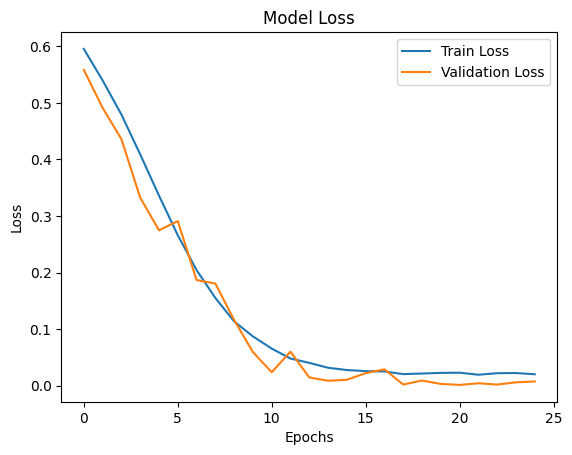

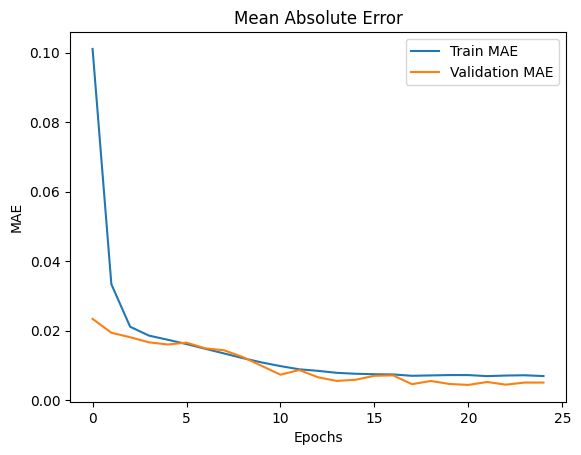

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, RepeatVector, TimeDistributed, Concatenate, Dropout, BatchNormalization, Lambda
import matplotlib.pyplot as plt
import os

# Enable device-agnostic compatibility
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print(f"Available GPUs: {len(physical_devices)}")
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No GPU found. Running on CPU.")

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow warnings

# Define R² score as a custom metric
def r2_score(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred), axis=None)
    y_true_mean = tf.reduce_mean(y_true, axis=None)
    ss_tot = tf.reduce_sum(tf.square(y_true - y_true_mean), axis=None)
    r2 = 1 - (ss_res / (ss_tot + tf.keras.backend.epsilon()))
    return r2

# Scale numerical features
def scale_features(data, features_to_scale):
    scalers = {}
    for feature in features_to_scale:
        scaler = MinMaxScaler()
        data[feature] = scaler.fit_transform(data[[feature]])
        scalers[feature] = scaler
    return data, scalers

# Add temporal and SegmentID features based on BaseDateTime
def add_temporal_features(data, time_col):
    data[time_col] = pd.to_datetime(data[time_col])
    data['Hour'] = data[time_col].dt.hour
    data['Minute'] = data[time_col].dt.minute
    data['Second'] = data[time_col].dt.second
    data['TimeDelta'] = data[time_col].diff().dt.total_seconds().fillna(0)
    return data

# Prepare sequences with temporal features and SegmentID
def prepare_sequences(data, enc_pattern, enc_segment, window_size, prediction_horizon, group_col='SegmentID', time_col='BaseDateTime'):
    data['Pattern'] = np.argmax(data[['Pattern_High Speed', 'Pattern_Slow Movement', 'Pattern_Stationary']].values, axis=1)

    # Encode pattern and SegmentID
    pattern_encoded = enc_pattern.transform(data[['Pattern']])
    segment_encoded = enc_segment.transform(data[[group_col]])
    data['Pattern_Encoded'] = list(pattern_encoded)
    data['SegmentID_Encoded'] = list(segment_encoded)

    sequences = []
    unique_segments = data[group_col].unique()

    for segment in unique_segments:
        segment_data = data[data[group_col] == segment].reset_index(drop=True)
        for start in range(len(segment_data) - window_size - prediction_horizon + 1):
            x_window = segment_data.iloc[start:start+window_size]
            y_window = segment_data.iloc[start+window_size:start+window_size+prediction_horizon]
            sequences.append({
                'X': {
                    'LAT': x_window['LAT'].tolist(),
                    'LON': x_window['LON'].tolist(),
                    'SOG': x_window['SOG'].tolist(),
                    'Hour': x_window['Hour'].tolist(),
                    'Minute': x_window['Minute'].tolist(),
                    'Second': x_window['Second'].tolist(),
                    'TimeDelta': x_window['TimeDelta'].tolist(),
                    'Patterns': x_window['Pattern_Encoded'].tolist(),
                    'SegmentID': x_window['SegmentID_Encoded'].tolist(),
                },
                'Y': {
                    'LAT': y_window['LAT'].tolist(),
                    'LON': y_window['LON'].tolist(),
                    'SOG': y_window['SOG'].tolist(),
                    'Hour': y_window['Hour'].tolist(),
                    'Minute': y_window['Minute'].tolist(),
                    'Second': y_window['Second'].tolist(),
                    'TimeDelta': y_window['TimeDelta'].tolist(),
                    'Patterns': y_window['Pattern_Encoded'].tolist(),
                    'SegmentID': y_window['SegmentID_Encoded'].tolist(),
                }
            })
    return sequences

# Split data into train/val/test
def split_train_val_test(data, test_size=0.2, val_size=0.2):
    train_data, temp_data = train_test_split(data, test_size=test_size + val_size, random_state=42, shuffle=True)
    val_data, test_data = train_test_split(temp_data, test_size=test_size / (test_size + val_size), random_state=42, shuffle=True)
    return train_data, val_data, test_data

# Data preparation pipeline with SegmentID encoding
def prepare_data_pipeline(data, window_size, prediction_horizon, test_size=0.2, val_size=0.2):
    # Add Pattern column
    data['Pattern'] = np.argmax(data[['Pattern_High Speed', 'Pattern_Slow Movement', 'Pattern_Stationary']].values, axis=1)

    # Add temporal features
    data = add_temporal_features(data, 'BaseDateTime')

    # Scale LAT, LON, SOG, and TimeDelta
    features_to_scale = ['LAT', 'LON', 'SOG', 'TimeDelta']
    data, scalers = scale_features(data, features_to_scale)

    # Fit encoders for Pattern and SegmentID
    enc_pattern = OneHotEncoder(sparse_output=False)
    enc_segment = OneHotEncoder(sparse_output=False)
    enc_pattern.fit(data[['Pattern']])
    enc_segment.fit(data[['SegmentID']])

    # Split data
    train_data, val_data, test_data = split_train_val_test(data, test_size, val_size)

    # Prepare sequences
    train_sequences = prepare_sequences(train_data, enc_pattern, enc_segment, window_size, prediction_horizon)
    val_sequences = prepare_sequences(val_data, enc_pattern, enc_segment, window_size, prediction_horizon)
    test_sequences = prepare_sequences(test_data, enc_pattern, enc_segment, window_size, prediction_horizon)

    return train_sequences, val_sequences, test_sequences, scalers, enc_pattern, enc_segment

# Create model inputs with SegmentID
def create_model_inputs(sequences, observed_seq_len, predicted_seq_len, feature_dim):
    encoder_inputs, decoder_inputs, outputs = [], [], []

    for sequence in sequences:
        X_features = np.array([
            sequence['X']['LAT'], sequence['X']['LON'], sequence['X']['SOG'], sequence['X']['Hour'],
            sequence['X']['Minute'], sequence['X']['Second'], sequence['X']['TimeDelta']
        ]).T
        X_patterns = np.array(sequence['X']['Patterns'])
        X_segments = np.array(sequence['X']['SegmentID'])

        encoder_input = np.concatenate([X_features, X_patterns, X_segments], axis=1)
        decoder_input = np.concatenate([
            np.array([
                sequence['Y']['LAT'], sequence['Y']['LON'], sequence['Y']['SOG'], sequence['Y']['Hour'],
                sequence['Y']['Minute'], sequence['Y']['Second'], sequence['Y']['TimeDelta']
            ]).T,
            np.array(sequence['Y']['Patterns']),
            np.array(sequence['Y']['SegmentID'])
        ], axis=1)

        encoder_inputs.append(encoder_input)
        decoder_inputs.append(decoder_input)
        outputs.append(decoder_input)

    return np.array(encoder_inputs), np.array(decoder_inputs), np.array(outputs)

# Create the model
def create_model(observed_seq_len, predicted_seq_len, feature_dim, hidden_units=128):
    encoder_inputs = Input(shape=(observed_seq_len, feature_dim), name="encoder_inputs")
    encoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True, name="encoder_lstm")
    encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)

    attention = Attention(name="attention_layer")
    attention_context = attention([encoder_outputs, encoder_outputs])
    attention_context = Lambda(lambda x: tf.reduce_mean(x, axis=1), name="summarize_attention")(attention_context)
    context_repeated = RepeatVector(predicted_seq_len)(attention_context)

    decoder_inputs = Input(shape=(predicted_seq_len, feature_dim), name="decoder_inputs")
    decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True, name="decoder_lstm")
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=[encoder_state_h, encoder_state_c])

    merged_context = Concatenate(axis=-1)([decoder_outputs, context_repeated])

    # Add more layers for complexity
    dense_layer_1 = TimeDistributed(Dense(hidden_units * 2, activation="relu"), name="dense_layer_1")(merged_context)
    dense_layer_1 = Dropout(0.4, name="dropout_1")(dense_layer_1)
    dense_layer_1 = BatchNormalization(name="batch_norm_1")(dense_layer_1)

    dense_layer_2 = TimeDistributed(Dense(hidden_units, activation="relu"), name="dense_layer_2")(dense_layer_1)
    dense_layer_2 = Dropout(0.4, name="dropout_2")(dense_layer_2)
    dense_layer_2 = BatchNormalization(name="batch_norm_2")(dense_layer_2)

    dense_layer_3 = TimeDistributed(Dense(hidden_units // 2, activation="relu"), name="dense_layer_3")(dense_layer_2)
    dense_layer_3 = Dropout(0.4, name="dropout_3")(dense_layer_3)
    dense_layer_3 = BatchNormalization(name="batch_norm_3")(dense_layer_3)

    dense_layer_4 = TimeDistributed(Dense(hidden_units // 4, activation="relu"), name="dense_layer_4")(dense_layer_3)
    dense_layer_4 = Dropout(0.4, name="dropout_4")(dense_layer_4)
    dense_layer_4 = BatchNormalization(name="batch_norm_4")(dense_layer_4)

    final_outputs = TimeDistributed(Dense(feature_dim, activation="linear"), name="final_outputs")(dense_layer_4)

    model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=final_outputs, name="complex_attention_lstm_model")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse", metrics=["mae", r2_score])

    return model

# Train function with device-agnostic compatibility and plot generation
def train_model(train_encoder_inputs, train_decoder_inputs, train_outputs,
                val_encoder_inputs, val_decoder_inputs, val_outputs,
                model_weights_path, observed_seq_len, predicted_seq_len, feature_dim, epochs=25, batch_size=16):

    # Check if weights exist
    if os.path.exists(model_weights_path):
        print("Loading existing model weights...")
        model = create_model(observed_seq_len, predicted_seq_len, feature_dim)
        model.load_weights(model_weights_path)
    else:
        print("No existing weights found. Creating a new model...")
        model = create_model(observed_seq_len, predicted_seq_len, feature_dim)

    # Use the appropriate device
    with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
        # Train the model
        history = model.fit(
            [train_encoder_inputs, train_decoder_inputs], train_outputs,
            validation_data=([val_encoder_inputs, val_decoder_inputs], val_outputs),
            epochs=epochs, batch_size=batch_size, verbose=1
        )

    # Save weights
    model.save_weights(model_weights_path)
    print(f"Model weights saved at {model_weights_path}")

    # Plot training and validation loss
    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig("loss_plot.png")
    print("Loss plot saved as loss_plot.png")

    # Plot additional metrics if available
    if 'mae' in history.history:
        plt.figure()
        plt.plot(history.history['mae'], label='Train MAE')
        plt.plot(history.history['val_mae'], label='Validation MAE')
        plt.title('Mean Absolute Error')
        plt.xlabel('Epochs')
        plt.ylabel('MAE')
        plt.legend()
        plt.savefig("mae_plot.png")
        print("MAE plot saved as mae_plot.png")

    return model

# Define parameters
window_size = 5
prediction_horizon = 2

# Assume df is your dataset
train_sequences, val_sequences, test_sequences, scalers, enc_pattern, enc_segment = prepare_data_pipeline(df, window_size, prediction_horizon)

# Calculate feature dimensions
observed_seq_len = window_size
predicted_seq_len = prediction_horizon
pattern_dim = enc_pattern.categories_[0].shape[0]
segment_dim = enc_segment.categories_[0].shape[0]
feature_dim = 7 + pattern_dim + segment_dim  # LAT, LON, SOG, Hour, Minute, Second, TimeDelta, Patterns, SegmentID

# Prepare model inputs
train_encoder_inputs, train_decoder_inputs, train_outputs = create_model_inputs(train_sequences, observed_seq_len, predicted_seq_len, feature_dim)
val_encoder_inputs, val_decoder_inputs, val_outputs = create_model_inputs(val_sequences, observed_seq_len, predicted_seq_len, feature_dim)

test_encoder_inputs, test_decoder_inputs, test_outputs = create_model_inputs(test_sequences, observed_seq_len, predicted_seq_len, feature_dim)

# Train the model
model_weights_path = "/content/seq2seq_tf.weights.h5"
trained_model = train_model(train_encoder_inputs, train_decoder_inputs, train_outputs,
                            val_encoder_inputs, val_decoder_inputs, val_outputs,
                            model_weights_path, observed_seq_len, predicted_seq_len, feature_dim)




In [9]:
# Function to test the model on test data
def test_model(model, test_encoder_inputs, test_decoder_inputs, test_outputs, scalers, output_file="test_results.png"):
    # Predict outputs
    predictions = model.predict([test_encoder_inputs, test_decoder_inputs], verbose=1)

    # Rescale the predicted and actual outputs to their original scale
    num_samples = predictions.shape[0]
    num_timesteps = predictions.shape[1]
    num_features = predictions.shape[2]

    actual_rescaled = []
    predicted_rescaled = []

    for sample_idx in range(num_samples):
        sample_actual = predictions[sample_idx]
        sample_pred = test_outputs[sample_idx]

        # Rescale LAT, LON, SOG, and TimeDelta back to their original values
        actual_lat = scalers['LAT'].inverse_transform(sample_actual[:, 0].reshape(-1, 1)).flatten()
        actual_lon = scalers['LON'].inverse_transform(sample_actual[:, 1].reshape(-1, 1)).flatten()
        pred_lat = scalers['LAT'].inverse_transform(sample_pred[:, 0].reshape(-1, 1)).flatten()
        pred_lon = scalers['LON'].inverse_transform(sample_pred[:, 1].reshape(-1, 1)).flatten()

        actual_rescaled.append((actual_lat, actual_lon))
        predicted_rescaled.append((pred_lat, pred_lon))

    # Visualize results for a few samples
    # plt.figure(figsize=(12, 6))
    # for idx in range(min(5, num_samples)):  # Visualize up to 5 sequences
    #     plt.subplot(2, 3, idx + 1)
    #     plt.plot(actual_rescaled[idx][0], actual_rescaled[idx][1], label="Actual Path", marker="o")
    #     plt.plot(predicted_rescaled[idx][0], predicted_rescaled[idx][1], label="Predicted Path", marker="x")
    #     plt.title(f"Sample {idx + 1} - Predicted vs Actual")
    #     plt.xlabel("Latitude")
    #     plt.ylabel("Longitude")
    #     plt.legend()

    # plt.tight_layout()
    # plt.savefig(output_file)
    # print(f"Test results plot saved as {output_file}")
    # plt.show()

    # Evaluate model performance
    test_loss, test_mae, test_r2 = model.evaluate(
        [test_encoder_inputs, test_decoder_inputs], test_outputs, verbose=1
    )
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test MAE: {test_mae:.4f}")
    print(f"Test R² Score: {test_r2:.4f}")

# Test the trained model
test_model(trained_model, test_encoder_inputs, test_decoder_inputs, test_outputs, scalers)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0020 - mae: 0.0052 - r2_score: 0.9980
Test Loss: 0.0020
Test MAE: 0.0052
Test R² Score: 0.9980


In [56]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# ------------------ Functions for Input Preparation ------------------

def prepare_single_sequence(observed_data, enc_pattern, enc_segment):
    numerical_features = observed_data[['LAT', 'LON', 'SOG', 'Hour', 'Minute', 'Second', 'TimeDelta']].values.astype(np.float32)
    pattern_encoded = enc_pattern.transform(observed_data[['Pattern']]).astype(np.float32)
    segment_encoded = enc_segment.transform(observed_data[['SegmentID']]).astype(np.float32)
    combined_features = np.hstack([numerical_features, pattern_encoded, segment_encoded])
    return combined_features

def prepare_decoder_initial_input(last_row, enc_pattern, enc_segment, predicted_seq_len):
    numerical_features = last_row[['LAT', 'LON', 'SOG', 'Hour', 'Minute', 'Second', 'TimeDelta']].values.astype(np.float32)
    numerical_features = np.tile(numerical_features, (predicted_seq_len, 1))
    pattern_encoded = enc_pattern.transform([[last_row['Pattern']]]).astype(np.float32)
    segment_encoded = enc_segment.transform([[last_row['SegmentID']]]).astype(np.float32)
    pattern_repeated = np.tile(pattern_encoded, (predicted_seq_len, 1))
    segment_repeated = np.tile(segment_encoded, (predicted_seq_len, 1))
    combined_features = np.hstack([numerical_features, pattern_repeated, segment_repeated])
    return np.expand_dims(combined_features, axis=0)  # Shape: (1, predicted_seq_len, feature_dim)

# ------------------ Prediction Function with Inverse Scaling ------------------

def predict_and_format(model, encoder_input, decoder_input_init, base_datetime, time_delta, mmsi, segment_id, prediction_horizon, scalers):
    predictions = []
    decoder_input = decoder_input_init.copy()

    for step in range(prediction_horizon):
        prediction = model.predict([encoder_input, decoder_input], verbose=0)
        prediction_step = prediction[:, step, :]
        predictions.append(prediction_step[0])
        next_input = np.expand_dims(prediction_step, axis=1)
        decoder_input = np.concatenate([decoder_input[:, 1:, :], next_input], axis=1)

    predictions = np.array(predictions)
    lat_pred = scalers['LAT'].inverse_transform(predictions[:, 0].reshape(-1, 1)).flatten()
    lon_pred = scalers['LON'].inverse_transform(predictions[:, 1].reshape(-1, 1)).flatten()
    sog_pred = scalers['SOG'].inverse_transform(predictions[:, 2].reshape(-1, 1)).flatten()

    future_datetimes = [base_datetime + pd.Timedelta(seconds=time_delta * i) for i in range(1, prediction_horizon + 1)]
    return pd.DataFrame({
        "BaseDateTime": future_datetimes,
        "LAT": lat_pred,
        "LON": lon_pred,
        "SOG": sog_pred,
        "MMSI": [mmsi] * prediction_horizon,
        "SegmentID": [segment_id] * prediction_horizon
    })

# ------------------ Main Prediction Pipeline ------------------

def preprocess_and_predict_with_weights(weights_path, data, base_datetime_col, mmsi_col, segment_col, observed_seq_len, predicted_seq_len, time_delta):
    observed_data = data.iloc[:observed_seq_len]
    base_datetime = pd.to_datetime(observed_data[base_datetime_col].iloc[-1])
    mmsi = data[mmsi_col].iloc[0]
    segment_id = data[segment_col].iloc[0]

    print("\n===== Observed Data =====")
    print(observed_data)

    enc_pattern = OneHotEncoder(sparse_output=False).fit(data[['Pattern']])
    enc_segment = OneHotEncoder(sparse_output=False).fit(data[[segment_col]])
    scalers = {}
    features_to_scale = ['LAT', 'LON', 'SOG']
    for feature in features_to_scale:
        scaler = MinMaxScaler()
        data[feature] = scaler.fit_transform(data[[feature]])
        scalers[feature] = scaler

    encoder_input = np.expand_dims(prepare_single_sequence(observed_data, enc_pattern, enc_segment), axis=0)
    decoder_input_init = prepare_decoder_initial_input(observed_data.iloc[-1], enc_pattern, enc_segment, predicted_seq_len)

    model = create_model(observed_seq_len, predicted_seq_len, encoder_input.shape[-1])
    model.load_weights(weights_path)

    predicted_output = predict_and_format(model, encoder_input, decoder_input_init, base_datetime, time_delta, mmsi, segment_id, predicted_seq_len, scalers)
    return observed_data, predicted_output

# ------------------ Example Usage ------------------

weights_path = "./seq2seq_tf.weights.h5"
observed_seq_len = 3
predicted_seq_len = 2
time_delta = 10
base_datetime_col = "BaseDateTime"
mmsi_col = "MMSI"
segment_col = "SegmentID"

observed_data, predicted_output = preprocess_and_predict_with_weights(
    weights_path=weights_path,
    data=df,
    base_datetime_col=base_datetime_col,
    mmsi_col=mmsi_col,
    segment_col=segment_col,
    observed_seq_len=observed_seq_len,
    predicted_seq_len=predicted_seq_len,
    time_delta=time_delta
)

print("\n===== Predicted Output =====")
print(predicted_output)



===== Observed Data =====
         BaseDateTime       LAT       LON     MMSI  Pattern_High Speed  \
0 2022-03-31 00:00:17  0.268091  0.834986  1056261                 0.0   
1 2022-03-31 00:00:27  0.268091  0.834986  1056261                 0.0   
2 2022-03-31 00:00:37  0.268091  0.834986  1056261                 0.0   

   Pattern_Slow Movement  Pattern_Stationary       SOG  SegmentID  Pattern  \
0                    0.0                 1.0  0.024390          0        2   
1                    0.0                 1.0  0.020392          0        2   
2                    0.0                 1.0  0.016393          0        2   

   Hour  Minute  Second  TimeDelta Pattern_Encoded  \
0     0       0      17   0.952153           [1.0]   
1     0       0      27   1.000000           [1.0]   
2     0       0      37   1.000000           [1.0]   

                                   SegmentID_Encoded  
0  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



===== Predicted Output =====
         BaseDateTime       LAT       LON       SOG     MMSI  SegmentID
0 2022-03-31 00:00:47  0.491821  0.706246  0.009728  1056261          0
1 2022-03-31 00:00:57  0.491865  0.706736  0.009605  1056261          0


In [42]:
df.head()

,BaseDateTime,LAT,LON,MMSI,Pattern_High Speed,Pattern_Slow Movement,Pattern_Stationary,SOG,SegmentID,Pattern,Hour,Minute,Second,TimeDelta,Pattern_Encoded,SegmentID_Encoded
0,2022-03-31 00:00:17,0.268091,0.834986,1056261,0.0,0.0,1.0,0.024390,0,2,0,0,17,0.952153,[1.0],"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2022-03-31 00:00:27,0.268091,0.834986,1056261,0.0,0.0,1.0,0.020392,0,2,0,0,27,1.000000,[1.0],"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2022-03-31 00:00:37,0.268091,0.834986,1056261,0.0,0.0,1.0,0.016393,0,2,0,0,37,1.000000,[1.0],"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,2022-03-31 00:00:47,0.268091,0.834986,1056261,0.0,0.0,1.0,0.012395,0,2,0,0,47,1.000000,[1.0],"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,2022-03-31 00:00:57,0.268091,0.834986,1056261,0.0,0.0,1.0,0.008397,0,2,0,0,57,1.000000,[1.0],"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Prediction:
it will work on single MMSI


In [45]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

def predict_and_format(model, encoder_input, decoder_input, base_datetime, time_delta, mmsi, segment_id, prediction_horizon, scalers=None):
    """
    Predict the next sequence and format the output as a DataFrame.

    Parameters:
    - model: Trained Keras model for sequence-to-sequence prediction.
    - encoder_input: Input for the encoder, shaped as (1, observed_seq_len, feature_dim).
    - decoder_input: Initial input for the decoder, shaped as (1, predicted_seq_len, feature_dim).
    - base_datetime: The base datetime for the start of predictions.
    - time_delta: Time step interval in seconds for predictions.
    - mmsi: MMSI identifier for the sequence.
    - segment_id: Segment ID associated with the predictions.
    - prediction_horizon: Number of steps to predict.
    - scalers: Optional dictionary of scalers for inverse transformation (keys: 'LAT', 'LON', 'SOG').

    Returns:
    - A DataFrame containing the predictions with timestamps and other details.
    """
    # Ensure inputs are in float32
    encoder_input = encoder_input.astype(np.float32)
    decoder_input = decoder_input.astype(np.float32)

    # Predict the output sequence
    predicted_sequence = model.predict([encoder_input, decoder_input], verbose=0)[0]

    # Generate timestamps for predictions
    future_datetimes = [base_datetime + pd.Timedelta(seconds=time_delta * i) for i in range(1, prediction_horizon + 1)]

    # Extract predicted values
    lat_pred = predicted_sequence[:, 0]
    lon_pred = predicted_sequence[:, 1]
    sog_pred = predicted_sequence[:, 2]

    # Decode pattern predictions (assumes patterns are one-hot encoded)
    pattern_pred = np.argmax(predicted_sequence[:, 3:6], axis=1)
    pattern_high_speed = (pattern_pred == 0).astype(int)
    pattern_slow_movement = (pattern_pred == 1).astype(int)
    pattern_stationary = (pattern_pred == 2).astype(int)

    # Optional: Inverse transform latitude, longitude, and speed
    if scalers:
        if 'LAT' in scalers:
            lat_pred = scalers['LAT'].inverse_transform(lat_pred.reshape(-1, 1)).flatten()
        if 'LON' in scalers:
            lon_pred = scalers['LON'].inverse_transform(lon_pred.reshape(-1, 1)).flatten()
        if 'SOG' in scalers:
            sog_pred = scalers['SOG'].inverse_transform(sog_pred.reshape(-1, 1)).flatten()

    # Create the output DataFrame
    output_df = pd.DataFrame({
        "BaseDateTime": future_datetimes,
        "LAT": lat_pred,
        "LON": lon_pred,
        "MMSI": [mmsi] * prediction_horizon,
        "Pattern_High Speed": pattern_high_speed,
        "Pattern_Slow Movement": pattern_slow_movement,
        "Pattern_Stationary": pattern_stationary,
        "SOG": sog_pred,
        "SegmentID": [segment_id] * prediction_horizon
    })

    return output_df

# Helper function to prepare a single sequence
def prepare_single_sequence(observed_data, enc_pattern, enc_segment):
    numerical_features = observed_data[['LAT', 'LON', 'SOG', 'Hour', 'Minute', 'Second', 'TimeDelta']].values.astype(np.float32)
    pattern_encoded = enc_pattern.transform(observed_data[['Pattern']]).astype(np.float32)
    segment_encoded = enc_segment.transform(observed_data[['SegmentID']]).astype(np.float32)
    combined_features = np.hstack([numerical_features, pattern_encoded, segment_encoded])
    return combined_features

# Helper function to prepare the initial decoder input
def prepare_decoder_initial_input(last_row, enc_pattern, enc_segment, predicted_seq_len):
    numerical_features = last_row[['LAT', 'LON', 'SOG', 'Hour', 'Minute', 'Second', 'TimeDelta']].values.astype(np.float32)
    numerical_features = np.tile(numerical_features, (predicted_seq_len, 1))
    pattern_encoded = enc_pattern.transform([[last_row['Pattern']]]).astype(np.float32)
    segment_encoded = enc_segment.transform([[last_row['SegmentID']]]).astype(np.float32)
    pattern_repeated = np.tile(pattern_encoded, (predicted_seq_len, 1))
    segment_repeated = np.tile(segment_encoded, (predicted_seq_len, 1))
    combined_features = np.hstack([numerical_features, pattern_repeated, segment_repeated])
    return combined_features

# Example usage
def preprocess_and_predict_with_weights(weights_path, data, base_datetime_col, mmsi_col, segment_col, observed_seq_len, predicted_seq_len, time_delta):
    """
    Preprocess data and perform prediction using a pre-trained model.

    Parameters:
    - weights_path: Path to the saved model weights.
    - data: DataFrame containing the input data.
    - base_datetime_col: Column name for the base datetime.
    - mmsi_col: Column name for the MMSI.
    - segment_col: Column name for the Segment ID.
    - observed_seq_len: Length of the observed sequence.
    - predicted_seq_len: Length of the predicted sequence.
    - time_delta: Time step interval in seconds for predictions.

    Returns:
    - A DataFrame containing the predicted outputs.
    """
    # Load the model and weights
    observed_data = data.iloc[:observed_seq_len]
    print("Observed Sequence:")
    print(observed_data)
    base_datetime = pd.to_datetime(observed_data[base_datetime_col].iloc[-1])  # Set to the last observed timestamp
    mmsi = data[mmsi_col].iloc[0]
    segment_id = data[segment_col].iloc[0]

    # Prepare encoders
    enc_pattern = OneHotEncoder(sparse_output=False).fit(data[['Pattern']])
    enc_segment = OneHotEncoder(sparse_output=False).fit(data[[segment_col]])

    # Scale features
    scalers = {}
    features_to_scale = ['LAT', 'LON', 'SOG']
    for feature in features_to_scale:
        scaler = MinMaxScaler()
        data[feature] = scaler.fit_transform(data[[feature]])
        scalers[feature] = scaler

    # Prepare inputs
    encoder_input = np.expand_dims(prepare_single_sequence(observed_data, enc_pattern, enc_segment), axis=0)
    decoder_input = np.expand_dims(prepare_decoder_initial_input(observed_data.iloc[-1], enc_pattern, enc_segment, predicted_seq_len), axis=0)

    # Build the model
    model = create_model(observed_seq_len, predicted_seq_len, encoder_input.shape[-1])
    model.load_weights(weights_path)

    # Perform prediction
    predicted_output = predict_and_format(
        model=model,
        encoder_input=encoder_input,
        decoder_input=decoder_input,
        base_datetime=base_datetime,  # Use the last timestamp as the starting point
        time_delta=time_delta,
        mmsi=mmsi,
        segment_id=segment_id,
        prediction_horizon=predicted_seq_len,
        scalers=scalers
    )

    return predicted_output

weights_path = "/content/seq2seq_tf.weights.h5"
observed_seq_len = 10
predicted_seq_len = 5
time_delta = 10
base_datetime_col = "BaseDateTime"
mmsi_col = "MMSI"
segment_col = "SegmentID"

# Perform prediction with preprocessing
predicted_output = preprocess_and_predict_with_weights(
    weights_path=weights_path,
    data=df,
    base_datetime_col=base_datetime_col,
    mmsi_col=mmsi_col,
    segment_col=segment_col,
    observed_seq_len=observed_seq_len,
    predicted_seq_len=predicted_seq_len,
    time_delta=time_delta
)

# Print the output DataFrame
print(predicted_output)


Observed Sequence:
         BaseDateTime       LAT       LON     MMSI  Pattern_High Speed  \
0 2022-03-31 00:00:17  0.268091  0.834986  1056261                 0.0   
1 2022-03-31 00:00:27  0.268091  0.834986  1056261                 0.0   
2 2022-03-31 00:00:37  0.268091  0.834986  1056261                 0.0   
3 2022-03-31 00:00:47  0.268091  0.834986  1056261                 0.0   
4 2022-03-31 00:00:57  0.268091  0.834986  1056261                 0.0   
5 2022-03-31 00:01:07  0.268091  0.834986  1056261                 0.0   
6 2022-03-31 00:01:17  0.268091  0.834986  1056261                 0.0   
7 2022-03-31 00:01:27  0.268091  0.834986  1056261                 0.0   
8 2022-03-31 00:01:37  0.268091  0.834986  1056261                 0.0   
9 2022-03-31 00:01:47  0.268091  0.834986  1056261                 0.0   

   Pattern_Slow Movement  Pattern_Stationary       SOG  SegmentID  Pattern  \
0                    0.0                 1.0  0.024390          0        2   
1         

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


         BaseDateTime       LAT       LON     MMSI  Pattern_High Speed  \
0 2022-03-31 00:01:57  0.493187  0.725556  1056261                   0   
1 2022-03-31 00:02:07  0.493879  0.735241  1056261                   0   
2 2022-03-31 00:02:17  0.494819  0.747328  1056261                   0   
3 2022-03-31 00:02:27  0.494837  0.747786  1056261                   0   
4 2022-03-31 00:02:37  0.494845  0.747967  1056261                   0   

   Pattern_Slow Movement  Pattern_Stationary       SOG  SegmentID  
0                      0                   1  0.004869          0  
1                      0                   1  0.002452          0  
2                      0                   1 -0.000575          0  
3                      0                   1 -0.000685          0  
4                      0                   1 -0.000729          0  


In [30]:
df.head()

,BaseDateTime,LAT,LON,MMSI,Pattern_High Speed,Pattern_Slow Movement,Pattern_Stationary,SOG,SegmentID,Pattern,Hour,Minute,Second,TimeDelta,Pattern_Encoded,SegmentID_Encoded
0,2022-03-31 00:00:17,0.268091,0.834986,1056261,0.0,0.0,1.0,0.024390,0,2,0,0,17,0.952153,[1.0],"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2022-03-31 00:00:27,0.268091,0.834986,1056261,0.0,0.0,1.0,0.020392,0,2,0,0,27,1.000000,[1.0],"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2022-03-31 00:00:37,0.268091,0.834986,1056261,0.0,0.0,1.0,0.016393,0,2,0,0,37,1.000000,[1.0],"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,2022-03-31 00:00:47,0.268091,0.834986,1056261,0.0,0.0,1.0,0.012395,0,2,0,0,47,1.000000,[1.0],"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,2022-03-31 00:00:57,0.268091,0.834986,1056261,0.0,0.0,1.0,0.008397,0,2,0,0,57,1.000000,[1.0],"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Multiu attention model

No GPU found. Running on CPU.
No existing weights found. Creating a new model...
Epoch 1/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - loss: 0.6490 - mae: 0.2536 - r2_score: -0.1154 - val_loss: 0.4998 - val_mae: 0.0299 - val_r2_score: 0.1293
Epoch 2/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 0.4521 - mae: 0.1058 - r2_score: 0.2353 - val_loss: 0.4133 - val_mae: 0.0232 - val_r2_score: 0.2800
Epoch 3/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 161ms/step - loss: 0.3212 - mae: 0.0581 - r2_score: 0.4534 - val_loss: 0.3369 - val_mae: 0.0196 - val_r2_score: 0.4131
Epoch 4/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 222ms/step - loss: 0.2486 - mae: 0.0307 - r2_score: 0.6048 - val_loss: 0.1643 - val_mae: 0.0143 - val_r2_score: 0.7138
Epoch 5/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - loss: 0.1616 - mae: 0.0180 - r2_score: 0.7429 - val_loss: 0.1490 - val_mae: 0.0136 - val_r2_score: 0.7404
Epoch 6/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - loss: 0.0888 - mae: 0.0124 - r2_score: 0.8566 - val_loss: 0.062

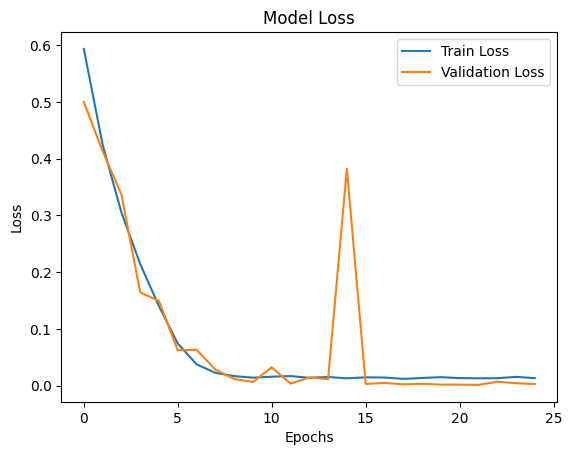

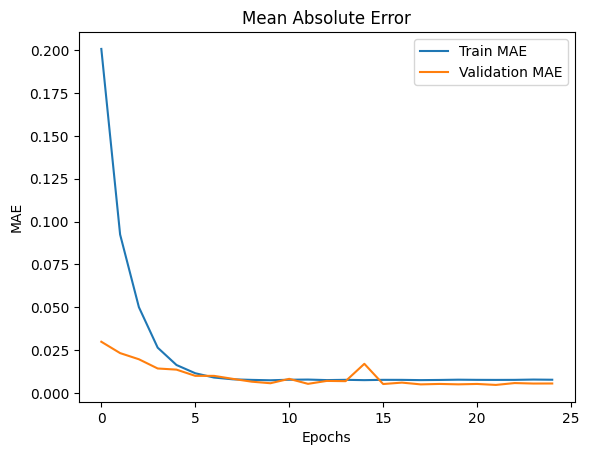

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, MultiHeadAttention, RepeatVector, TimeDistributed, Concatenate, Dropout, BatchNormalization, Lambda
import matplotlib.pyplot as plt
import os

# Enable device-agnostic compatibility
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print(f"Available GPUs: {len(physical_devices)}")
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No GPU found. Running on CPU.")

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow warnings

# Define R² score as a custom metric
def r2_score(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred), axis=None)
    y_true_mean = tf.reduce_mean(y_true, axis=None)
    ss_tot = tf.reduce_sum(tf.square(y_true - y_true_mean), axis=None)
    r2 = 1 - (ss_res / (ss_tot + tf.keras.backend.epsilon()))
    return r2

# Scale numerical features
def scale_features(data, features_to_scale):
    scalers = {}
    for feature in features_to_scale:
        scaler = MinMaxScaler()
        data[feature] = scaler.fit_transform(data[[feature]])
        scalers[feature] = scaler
    return data, scalers

# Add temporal and SegmentID features based on BaseDateTime
def add_temporal_features(data, time_col):
    data[time_col] = pd.to_datetime(data[time_col])
    data['Hour'] = data[time_col].dt.hour
    data['Minute'] = data[time_col].dt.minute
    data['Second'] = data[time_col].dt.second
    data['TimeDelta'] = data[time_col].diff().dt.total_seconds().fillna(0)
    return data

# Prepare sequences with temporal features and SegmentID
def prepare_sequences(data, enc_pattern, enc_segment, window_size, prediction_horizon, group_col='SegmentID', time_col='BaseDateTime'):
    data['Pattern'] = np.argmax(data[['Pattern_High Speed', 'Pattern_Slow Movement', 'Pattern_Stationary']].values, axis=1)

    # Encode pattern and SegmentID
    pattern_encoded = enc_pattern.transform(data[['Pattern']])
    segment_encoded = enc_segment.transform(data[[group_col]])
    data['Pattern_Encoded'] = list(pattern_encoded)
    data['SegmentID_Encoded'] = list(segment_encoded)

    sequences = []
    unique_segments = data[group_col].unique()

    for segment in unique_segments:
        segment_data = data[data[group_col] == segment].reset_index(drop=True)
        for start in range(len(segment_data) - window_size - prediction_horizon + 1):
            x_window = segment_data.iloc[start:start+window_size]
            y_window = segment_data.iloc[start+window_size:start+window_size+prediction_horizon]
            sequences.append({
                'X': {
                    'LAT': x_window['LAT'].tolist(),
                    'LON': x_window['LON'].tolist(),
                    'SOG': x_window['SOG'].tolist(),
                    'Hour': x_window['Hour'].tolist(),
                    'Minute': x_window['Minute'].tolist(),
                    'Second': x_window['Second'].tolist(),
                    'TimeDelta': x_window['TimeDelta'].tolist(),
                    'Patterns': x_window['Pattern_Encoded'].tolist(),
                    'SegmentID': x_window['SegmentID_Encoded'].tolist(),
                },
                'Y': {
                    'LAT': y_window['LAT'].tolist(),
                    'LON': y_window['LON'].tolist(),
                    'SOG': y_window['SOG'].tolist(),
                    'Hour': y_window['Hour'].tolist(),
                    'Minute': y_window['Minute'].tolist(),
                    'Second': y_window['Second'].tolist(),
                    'TimeDelta': y_window['TimeDelta'].tolist(),
                    'Patterns': y_window['Pattern_Encoded'].tolist(),
                    'SegmentID': y_window['SegmentID_Encoded'].tolist(),
                }
            })
    return sequences

# Split data into train/val/test
def split_train_val_test(data, test_size=0.2, val_size=0.2):
    train_data, temp_data = train_test_split(data, test_size=test_size + val_size, random_state=42, shuffle=True)
    val_data, test_data = train_test_split(temp_data, test_size=test_size / (test_size + val_size), random_state=42, shuffle=True)
    return train_data, val_data, test_data

# Data preparation pipeline with SegmentID encoding
def prepare_data_pipeline(data, window_size, prediction_horizon, test_size=0.2, val_size=0.2):
    # Add Pattern column
    data['Pattern'] = np.argmax(data[['Pattern_High Speed', 'Pattern_Slow Movement', 'Pattern_Stationary']].values, axis=1)

    # Add temporal features
    data = add_temporal_features(data, 'BaseDateTime')

    # Scale LAT, LON, SOG, and TimeDelta
    features_to_scale = ['LAT', 'LON', 'SOG', 'TimeDelta']
    data, scalers = scale_features(data, features_to_scale)

    # Fit encoders for Pattern and SegmentID
    enc_pattern = OneHotEncoder(sparse_output=False)
    enc_segment = OneHotEncoder(sparse_output=False)
    enc_pattern.fit(data[['Pattern']])
    enc_segment.fit(data[['SegmentID']])

    # Split data
    train_data, val_data, test_data = split_train_val_test(data, test_size, val_size)

    # Prepare sequences
    train_sequences = prepare_sequences(train_data, enc_pattern, enc_segment, window_size, prediction_horizon)
    val_sequences = prepare_sequences(val_data, enc_pattern, enc_segment, window_size, prediction_horizon)
    test_sequences = prepare_sequences(test_data, enc_pattern, enc_segment, window_size, prediction_horizon)

    return train_sequences, val_sequences, test_sequences, scalers, enc_pattern, enc_segment

# Create model inputs with SegmentID
def create_model_inputs(sequences, observed_seq_len, predicted_seq_len, feature_dim):
    encoder_inputs, decoder_inputs, outputs = [], [], []

    for sequence in sequences:
        X_features = np.array([
            sequence['X']['LAT'], sequence['X']['LON'], sequence['X']['SOG'], sequence['X']['Hour'],
            sequence['X']['Minute'], sequence['X']['Second'], sequence['X']['TimeDelta']
        ]).T
        X_patterns = np.array(sequence['X']['Patterns'])
        X_segments = np.array(sequence['X']['SegmentID'])

        encoder_input = np.concatenate([X_features, X_patterns, X_segments], axis=1)
        decoder_input = np.concatenate([
            np.array([
                sequence['Y']['LAT'], sequence['Y']['LON'], sequence['Y']['SOG'], sequence['Y']['Hour'],
                sequence['Y']['Minute'], sequence['Y']['Second'], sequence['Y']['TimeDelta']
            ]).T,
            np.array(sequence['Y']['Patterns']),
            np.array(sequence['Y']['SegmentID'])
        ], axis=1)

        encoder_inputs.append(encoder_input)
        decoder_inputs.append(decoder_input)
        outputs.append(decoder_input)

    return np.array(encoder_inputs), np.array(decoder_inputs), np.array(outputs)

# Create the model with Multi-Head Attention
def create_model(observed_seq_len, predicted_seq_len, feature_dim, hidden_units=128, num_heads=8):
    encoder_inputs = Input(shape=(observed_seq_len, feature_dim), name="encoder_inputs")
    encoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True, name="encoder_lstm")
    encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)

    # Multi-Head Attention Layer
    attention_layer = MultiHeadAttention(num_heads=num_heads, key_dim=hidden_units, name="multi_head_attention")
    attention_context = attention_layer(query=encoder_outputs, value=encoder_outputs, key=encoder_outputs)

    # Summarize attention output
    attention_summary = Lambda(lambda x: tf.reduce_mean(x, axis=1), name="summarize_attention")(attention_context)
    context_repeated = RepeatVector(predicted_seq_len)(attention_summary)

    decoder_inputs = Input(shape=(predicted_seq_len, feature_dim), name="decoder_inputs")
    decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True, name="decoder_lstm")
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=[encoder_state_h, encoder_state_c])

    merged_context = Concatenate(axis=-1)([decoder_outputs, context_repeated])

    # Add more layers for complexity
    dense_layer_1 = TimeDistributed(Dense(hidden_units * 2, activation="relu"), name="dense_layer_1")(merged_context)
    dense_layer_1 = Dropout(0.4, name="dropout_1")(dense_layer_1)
    dense_layer_1 = BatchNormalization(name="batch_norm_1")(dense_layer_1)

    dense_layer_2 = TimeDistributed(Dense(hidden_units, activation="relu"), name="dense_layer_2")(dense_layer_1)
    dense_layer_2 = Dropout(0.4, name="dropout_2")(dense_layer_2)
    dense_layer_2 = BatchNormalization(name="batch_norm_2")(dense_layer_2)

    final_outputs = TimeDistributed(Dense(feature_dim, activation="linear"), name="final_outputs")(dense_layer_2)

    model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=final_outputs, name="multi_head_attention_lstm_model")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse", metrics=["mae", r2_score])

    return model

# Train function with device-agnostic compatibility and plot generation
def train_model(train_encoder_inputs, train_decoder_inputs, train_outputs,
                val_encoder_inputs, val_decoder_inputs, val_outputs,
                model_weights_path, observed_seq_len, predicted_seq_len, feature_dim, epochs=25, batch_size=16):

    # Check if weights exist
    if os.path.exists(model_weights_path):
        print("Loading existing model weights...")
        model = create_model(observed_seq_len, predicted_seq_len, feature_dim)
        model.load_weights(model_weights_path)
    else:
        print("No existing weights found. Creating a new model...")
        model = create_model(observed_seq_len, predicted_seq_len, feature_dim)

    # Use the appropriate device
    with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
        # Train the model
        history = model.fit(
            [train_encoder_inputs, train_decoder_inputs], train_outputs,
            validation_data=([val_encoder_inputs, val_decoder_inputs], val_outputs),
            epochs=epochs, batch_size=batch_size, verbose=1
        )

    # Save weights
    model.save_weights(model_weights_path)
    print(f"Model weights saved at {model_weights_path}")

    # Plot training and validation loss
    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig("loss_plot.png")
    print("Loss plot saved as loss_plot.png")

    # Plot additional metrics if available
    if 'mae' in history.history:
        plt.figure()
        plt.plot(history.history['mae'], label='Train MAE')
        plt.plot(history.history['val_mae'], label='Validation MAE')
        plt.title('Mean Absolute Error')
        plt.xlabel('Epochs')
        plt.ylabel('MAE')
        plt.legend()
        plt.savefig("mae_plot.png")
        print("MAE plot saved as mae_plot.png")

    return model

# Define parameters
window_size = 5
prediction_horizon = 2

# Assume df is your dataset
train_sequences, val_sequences, test_sequences, scalers, enc_pattern, enc_segment = prepare_data_pipeline(df, window_size, prediction_horizon)

# Calculate feature dimensions
observed_seq_len = window_size
predicted_seq_len = prediction_horizon
pattern_dim = enc_pattern.categories_[0].shape[0]
segment_dim = enc_segment.categories_[0].shape[0]
feature_dim = 7 + pattern_dim + segment_dim  # LAT, LON, SOG, Hour, Minute, Second, TimeDelta, Patterns, SegmentID

# Prepare model inputs
train_encoder_inputs, train_decoder_inputs, train_outputs = create_model_inputs(train_sequences, observed_seq_len, predicted_seq_len, feature_dim)
val_encoder_inputs, val_decoder_inputs, val_outputs = create_model_inputs(val_sequences, observed_seq_len, predicted_seq_len, feature_dim)

test_encoder_inputs, test_decoder_inputs, test_outputs = create_model_inputs(test_sequences, observed_seq_len, predicted_seq_len, feature_dim)

# Train the model
model_weights_path = "seq2seq_multi_head_attention.weights.h5"
trained_model = train_model(train_encoder_inputs, train_decoder_inputs, train_outputs,
                            val_encoder_inputs, val_decoder_inputs, val_outputs,
                            model_weights_path, observed_seq_len, predicted_seq_len, feature_dim)


### Pred Function
it will work on Single MMSI

In [ ]:
# Helper function to prepare a single sequence for the encoder
def prepare_single_sequence(observed_data, enc_pattern, enc_segment):
    numerical_features = observed_data[['LAT', 'LON', 'SOG', 'Hour', 'Minute', 'Second', 'TimeDelta']].values.astype(np.float32)
    pattern_encoded = enc_pattern.transform(observed_data[['Pattern']]).astype(np.float32)
    segment_encoded = enc_segment.transform(observed_data[['SegmentID']]).astype(np.float32)
    combined_features = np.hstack([numerical_features, pattern_encoded, segment_encoded])
    return combined_features

# Helper function to prepare the initial decoder input
def prepare_decoder_initial_input(last_row, enc_pattern, enc_segment, predicted_seq_len):
    numerical_features = last_row[['LAT', 'LON', 'SOG', 'Hour', 'Minute', 'Second', 'TimeDelta']].values.astype(np.float32)
    numerical_features = np.tile(numerical_features, (predicted_seq_len, 1))
    pattern_encoded = enc_pattern.transform([[last_row['Pattern']]]).astype(np.float32)
    segment_encoded = enc_segment.transform([[last_row['SegmentID']]]).astype(np.float32)
    pattern_repeated = np.tile(pattern_encoded, (predicted_seq_len, 1))
    segment_repeated = np.tile(segment_encoded, (predicted_seq_len, 1))
    combined_features = np.hstack([numerical_features, pattern_repeated, segment_repeated])
    return combined_features

# Prediction function to make predictions and format the output
def predict_and_format(model, encoder_input, decoder_input, base_datetime, time_delta, mmsi, segment_id, prediction_horizon, scalers=None):
    """
    Predict the next sequence and format the output as a DataFrame.
    """
    # Ensure inputs are in float32
    encoder_input = encoder_input.astype(np.float32)
    decoder_input = decoder_input.astype(np.float32)

    # Predict the output sequence
    predicted_sequence = model.predict([encoder_input, decoder_input], verbose=0)[0]

    # Generate timestamps for predictions
    future_datetimes = [base_datetime + pd.Timedelta(seconds=time_delta * i) for i in range(1, prediction_horizon + 1)]

    # Extract predicted values
    lat_pred = predicted_sequence[:, 0]
    lon_pred = predicted_sequence[:, 1]
    sog_pred = predicted_sequence[:, 2]

    # Decode pattern predictions (assumes patterns are one-hot encoded)
    pattern_pred = np.argmax(predicted_sequence[:, 3:6], axis=1)
    pattern_high_speed = (pattern_pred == 0).astype(int)
    pattern_slow_movement = (pattern_pred == 1).astype(int)
    pattern_stationary = (pattern_pred == 2).astype(int)

    # Optional: Inverse transform latitude, longitude, and speed
    if scalers:
        if 'LAT' in scalers:
            lat_pred = scalers['LAT'].inverse_transform(lat_pred.reshape(-1, 1)).flatten()
        if 'LON' in scalers:
            lon_pred = scalers['LON'].inverse_transform(lon_pred.reshape(-1, 1)).flatten()
        if 'SOG' in scalers:
            sog_pred = scalers['SOG'].inverse_transform(sog_pred.reshape(-1, 1)).flatten()

    # Create the output DataFrame
    output_df = pd.DataFrame({
        "BaseDateTime": future_datetimes,
        "LAT": lat_pred,
        "LON": lon_pred,
        "MMSI": [mmsi] * prediction_horizon,
        "Pattern_High Speed": pattern_high_speed,
        "Pattern_Slow Movement": pattern_slow_movement,
        "Pattern_Stationary": pattern_stationary,
        "SOG": sog_pred,
        "SegmentID": [segment_id] * prediction_horizon
    })

    return output_df

# Preprocessing and prediction function
def preprocess_and_predict_with_weights(weights_path, data, base_datetime_col, mmsi_col, segment_col, observed_seq_len, predicted_seq_len, time_delta):
    """
    Preprocess data and perform prediction using a pre-trained model.
    """
    observed_data = data.iloc[:observed_seq_len]
    print("Observed Sequence:")
    print(observed_data)
    base_datetime = pd.to_datetime(observed_data[base_datetime_col].iloc[-1])
    mmsi = data[mmsi_col].iloc[0]
    segment_id = data[segment_col].iloc[0]

    # Prepare encoders
    enc_pattern = OneHotEncoder(sparse_output=False).fit(data[['Pattern']])
    enc_segment = OneHotEncoder(sparse_output=False).fit(data[[segment_col]])

    # Scale features
    scalers = {}
    features_to_scale = ['LAT', 'LON', 'SOG']
    for feature in features_to_scale:
        scaler = MinMaxScaler()
        data[feature] = scaler.fit_transform(data[[feature]])
        scalers[feature] = scaler

    # Prepare inputs
    encoder_input = np.expand_dims(prepare_single_sequence(observed_data, enc_pattern, enc_segment), axis=0)
    decoder_input = np.expand_dims(prepare_decoder_initial_input(observed_data.iloc[-1], enc_pattern, enc_segment, predicted_seq_len), axis=0)

    # Build the model
    feature_dim = encoder_input.shape[-1]
    model = create_model(observed_seq_len, predicted_seq_len, feature_dim)
    model.load_weights(weights_path)

    # Perform prediction
    predicted_output = predict_and_format(
        model=model,
        encoder_input=encoder_input,
        decoder_input=decoder_input,
        base_datetime=base_datetime,
        time_delta=time_delta,
        mmsi=mmsi,
        segment_id=segment_id,
        prediction_horizon=predicted_seq_len,
        scalers=scalers
    )

    return predicted_output


weights_path = "seq2seq_multi_head_attention.weights.h5"
observed_seq_len = 10
predicted_seq_len = 5
time_delta = 10
base_datetime_col = "BaseDateTime"
mmsi_col = "MMSI"
segment_col = "SegmentID"


predicted_output = preprocess_and_predict_with_weights(
    weights_path=weights_path,
    data=df,
    base_datetime_col=base_datetime_col,
    mmsi_col=mmsi_col,
    segment_col=segment_col,
    observed_seq_len=observed_seq_len,
    predicted_seq_len=predicted_seq_len,
    time_delta=time_delta
)


print(predicted_output)

Observed Sequence:
         BaseDateTime       LAT       LON     MMSI  Pattern_High Speed  \
0 2022-03-31 00:00:17  0.268091  0.834986  1056261                 0.0   
1 2022-03-31 00:00:27  0.268091  0.834986  1056261                 0.0   
2 2022-03-31 00:00:37  0.268091  0.834986  1056261                 0.0   
3 2022-03-31 00:00:47  0.268091  0.834986  1056261                 0.0   
4 2022-03-31 00:00:57  0.268091  0.834986  1056261                 0.0   
5 2022-03-31 00:01:07  0.268091  0.834986  1056261                 0.0   
6 2022-03-31 00:01:17  0.268091  0.834986  1056261                 0.0   
7 2022-03-31 00:01:27  0.268091  0.834986  1056261                 0.0   
8 2022-03-31 00:01:37  0.268091  0.834986  1056261                 0.0   
9 2022-03-31 00:01:47  0.268091  0.834986  1056261                 0.0   

   Pattern_Slow Movement  Pattern_Stationary       SOG  SegmentID  Pattern  \
0                    0.0                 1.0  0.024390          0        2   
1         

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


         BaseDateTime       LAT       LON     MMSI  Pattern_High Speed  \
0 2022-03-31 00:01:57  0.600430  0.659549  1056261                   0   
1 2022-03-31 00:02:07  0.606337  0.653654  1056261                   0   
2 2022-03-31 00:02:17  0.605297  0.651523  1056261                   0   
3 2022-03-31 00:02:27  0.603790  0.650389  1056261                   0   
4 2022-03-31 00:02:37  0.602853  0.649758  1056261                   0   

   Pattern_Slow Movement  Pattern_Stationary       SOG  SegmentID  
0                      0                   1 -0.001466          0  
1                      0                   1 -0.005229          0  
2                      0                   1 -0.006182          0  
3                      0                   1 -0.006342          0  
4                      0                   1 -0.006465          0  


### Torch

### single attention

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# Dataset Preparation Pipeline
def add_temporal_features(data, time_col):
    data[time_col] = pd.to_datetime(data[time_col])
    data['Hour'] = data[time_col].dt.hour
    data['Minute'] = data[time_col].dt.minute
    data['Second'] = data[time_col].dt.second
    data['TimeDelta'] = data[time_col].diff().dt.total_seconds().fillna(0)
    return data

def scale_features(data, features_to_scale):
    scalers = {}
    for feature in features_to_scale:
        scaler = MinMaxScaler()
        data[feature] = scaler.fit_transform(data[[feature]])
        scalers[feature] = scaler
    return data, scalers

def prepare_sequences(data, enc_pattern, enc_segment, window_size, prediction_horizon, group_col='SegmentID'):
    data['Pattern'] = np.argmax(data[['Pattern_High Speed', 'Pattern_Slow Movement', 'Pattern_Stationary']].values, axis=1)
    pattern_encoded = enc_pattern.transform(data[['Pattern']])
    segment_encoded = enc_segment.transform(data[[group_col]])
    data['Pattern_Encoded'] = list(pattern_encoded)
    data['SegmentID_Encoded'] = list(segment_encoded)

    sequences = []
    unique_segments = data[group_col].unique()

    for segment in unique_segments:
        segment_data = data[data[group_col] == segment].reset_index(drop=True)
        for start in range(len(segment_data) - window_size - prediction_horizon + 1):
            x_window = segment_data.iloc[start:start+window_size]
            y_window = segment_data.iloc[start+window_size:start+window_size+prediction_horizon]
            sequences.append({
                'X': np.concatenate([
                    x_window[['LAT', 'LON', 'SOG', 'Hour', 'Minute', 'Second', 'TimeDelta']].values,
                    np.stack(x_window['Pattern_Encoded'].values),
                    np.stack(x_window['SegmentID_Encoded'].values)
                ], axis=1),
                'Y': np.concatenate([
                    y_window[['LAT', 'LON', 'SOG', 'Hour', 'Minute', 'Second', 'TimeDelta']].values,
                    np.stack(y_window['Pattern_Encoded'].values),
                    np.stack(y_window['SegmentID_Encoded'].values)
                ], axis=1)
            })
    return sequences

def prepare_data_pipeline(data, window_size, prediction_horizon, test_size=0.2, val_size=0.2):
    data['Pattern'] = np.argmax(data[['Pattern_High Speed', 'Pattern_Slow Movement', 'Pattern_Stationary']].values, axis=1)
    data = add_temporal_features(data, 'BaseDateTime')
    features_to_scale = ['LAT', 'LON', 'SOG', 'TimeDelta']
    data, scalers = scale_features(data, features_to_scale)
    enc_pattern = OneHotEncoder(sparse_output=False)
    enc_segment = OneHotEncoder(sparse_output=False)
    enc_pattern.fit(data[['Pattern']])
    enc_segment.fit(data[['SegmentID']])
    train_data, temp_data = train_test_split(data, test_size=test_size + val_size, random_state=42, shuffle=True)
    val_data, test_data = train_test_split(temp_data, test_size=test_size / (test_size + val_size), random_state=42, shuffle=True)
    train_sequences = prepare_sequences(train_data, enc_pattern, enc_segment, window_size, prediction_horizon)
    val_sequences = prepare_sequences(val_data, enc_pattern, enc_segment, window_size, prediction_horizon)
    test_sequences = prepare_sequences(test_data, enc_pattern, enc_segment, window_size, prediction_horizon)
    return train_sequences, val_sequences, test_sequences, scalers, enc_pattern, enc_segment

# PyTorch Dataset Class
class SequenceDataset(Dataset):
    def __init__(self, sequences):
        self.encoder_inputs = [torch.tensor(seq['X'], dtype=torch.float32) for seq in sequences]
        self.decoder_inputs = [torch.tensor(seq['Y'], dtype=torch.float32) for seq in sequences]
        self.outputs = [torch.tensor(seq['Y'], dtype=torch.float32) for seq in sequences]

    def __len__(self):
        return len(self.encoder_inputs)

    def __getitem__(self, idx):
        return self.encoder_inputs[idx], self.decoder_inputs[idx], self.outputs[idx]

# Model Definition
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size

    def forward(self, encoder_outputs, decoder_hidden):
        attn_weights = torch.bmm(encoder_outputs, decoder_hidden.unsqueeze(2)).squeeze(2)
        attn_weights = torch.softmax(attn_weights, dim=1)
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs).squeeze(1)
        return context, attn_weights

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_size):
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_size, batch_first=True)

    def forward(self, x):
        outputs, (hidden, cell) = self.lstm(x)
        return outputs, hidden, cell

class Decoder(nn.Module):
    def __init__(self, input_dim, hidden_size, output_dim):
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_size, batch_first=True)
        self.attention = Attention(hidden_size)
        self.fc = nn.Linear(hidden_size * 2, output_dim)

    def forward(self, x, hidden, cell, encoder_outputs):
        lstm_out, (hidden, cell) = self.lstm(x, (hidden, cell))
        context, attn_weights = self.attention(encoder_outputs, hidden[-1])
        lstm_out = lstm_out.squeeze(1)
        concat = torch.cat((lstm_out, context), dim=1)
        outputs = self.fc(concat)
        return outputs, hidden, cell, attn_weights

class Seq2Seq(nn.Module):
    def __init__(self, input_dim, hidden_size, output_dim, predicted_seq_len):
        super(Seq2Seq, self).__init__()
        self.encoder = Encoder(input_dim, hidden_size)
        self.decoder = Decoder(output_dim, hidden_size, output_dim)
        self.predicted_seq_len = predicted_seq_len

    def forward(self, encoder_inputs, decoder_inputs):
        encoder_outputs, hidden, cell = self.encoder(encoder_inputs)
        decoder_outputs = []
        input = decoder_inputs[:, 0, :].unsqueeze(1)
        for t in range(self.predicted_seq_len):
            output, hidden, cell, _ = self.decoder(input, hidden, cell, encoder_outputs)
            decoder_outputs.append(output)
            input = output.unsqueeze(1)
        decoder_outputs = torch.stack(decoder_outputs, dim=1)
        return decoder_outputs

# Metrics
def r2_score_metric(predictions, targets):
    ss_res = torch.sum((targets - predictions) ** 2)
    ss_tot = torch.sum((targets - torch.mean(targets)) ** 2)
    r2_score = 1 - (ss_res / (ss_tot + 1e-10))
    return r2_score.item()

def accuracy_metric(predictions, targets, tolerance=0.1):
    correct = torch.abs(predictions - targets) <= tolerance
    accuracy = correct.sum().item() / torch.numel(targets)
    return accuracy * 100

# Training Function
def train_model(model, train_loader, val_loader, optimizer, criterion, device, model_weights_path, epochs=25):
    model = model.to(device)

    # Check for pretrained weights
    if os.path.exists(model_weights_path):
        print(f"Loading pretrained weights from {model_weights_path}...")
        model.load_state_dict(torch.load(model_weights_path))
    else:
        print("No pretrained weights found. Starting training from scratch.")

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    train_r2_scores, val_r2_scores = [], []

    best_val_r2 = float('-inf')

    for epoch in range(epochs):
        model.train()
        train_loss, train_acc, train_r2 = 0, 0, 0
        for encoder_inputs, decoder_inputs, outputs in train_loader:
            encoder_inputs, decoder_inputs, outputs = (
                encoder_inputs.to(device),
                decoder_inputs.to(device),
                outputs.to(device),
            )
            optimizer.zero_grad()
            predictions = model(encoder_inputs, decoder_inputs)
            loss = criterion(predictions, outputs)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += accuracy_metric(predictions, outputs)
            train_r2 += r2_score_metric(predictions, outputs)

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        train_r2 /= len(train_loader)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        train_r2_scores.append(train_r2)

        model.eval()
        val_loss, val_acc, val_r2 = 0, 0, 0
        with torch.no_grad():
            for encoder_inputs, decoder_inputs, outputs in val_loader:
                encoder_inputs, decoder_inputs, outputs = (
                    encoder_inputs.to(device),
                    decoder_inputs.to(device),
                    outputs.to(device),
                )
                predictions = model(encoder_inputs, decoder_inputs)
                loss = criterion(predictions, outputs)

                val_loss += loss.item()
                val_acc += accuracy_metric(predictions, outputs)
                val_r2 += r2_score_metric(predictions, outputs)

        val_loss /= len(val_loader)
        val_acc /= len(val_loader)
        val_r2 /= len(val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_r2_scores.append(val_r2)

        # Save model if validation R² improves
        if val_r2 > best_val_r2:
            best_val_r2 = val_r2
            torch.save(model.state_dict(), model_weights_path)
            print(f"Model weights saved at {model_weights_path} (Epoch {epoch+1})")

        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, "
              f"Train R²: {train_r2:.4f}, Val R²: {val_r2:.4f}")

    return model

# Hyperparameters and Data Preparation
window_size = 5
prediction_horizon = 2
hidden_size = 128
batch_size = 16
epochs = 25
learning_rate = 0.001
model_weights_path = "seq2seq_model_best.pth"

# Assume df is your dataset
# Prepare data
train_sequences, val_sequences, test_sequences, scalers, enc_pattern, enc_segment = prepare_data_pipeline(df, window_size, prediction_horizon)

# Create DataLoaders
train_dataset = SequenceDataset(train_sequences)
val_dataset = SequenceDataset(val_sequences)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize Model, Optimizer, and Criterion
input_dim = train_sequences[0]['X'].shape[1]
output_dim = train_sequences[0]['Y'].shape[1]
predicted_seq_len = prediction_horizon
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Seq2Seq(input_dim, hidden_size, output_dim, predicted_seq_len)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Train the Model
trained_model = train_model(model, train_loader, val_loader, optimizer, criterion, device, model_weights_path, epochs)


Loading pretrained weights from seq2seq_model_best.pth...


<ipython-input-15-4421913375e2>:160: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weights_path))


Model weights saved at seq2seq_model_best.pth (Epoch 1)
Epoch 1/25, Train Loss: 0.1377, Val Loss: 0.2464, Train Acc: 67.58%, Val Acc: 63.66%, Train R²: 0.7628, Val R²: 0.5707
Epoch 2/25, Train Loss: 0.1243, Val Loss: 0.2469, Train Acc: 72.06%, Val Acc: 68.36%, Train R²: 0.7850, Val R²: 0.5699
Epoch 3/25, Train Loss: 0.1104, Val Loss: 0.2783, Train Acc: 74.54%, Val Acc: 60.53%, Train R²: 0.8087, Val R²: 0.5151
Epoch 4/25, Train Loss: 0.1056, Val Loss: 0.3142, Train Acc: 68.96%, Val Acc: 63.31%, Train R²: 0.8195, Val R²: 0.4526
Epoch 5/25, Train Loss: 0.0965, Val Loss: 0.2787, Train Acc: 70.97%, Val Acc: 69.58%, Train R²: 0.8320, Val R²: 0.5146
Epoch 6/25, Train Loss: 0.0847, Val Loss: 0.2592, Train Acc: 75.63%, Val Acc: 92.17%, Train R²: 0.8529, Val R²: 0.5485
Epoch 7/25, Train Loss: 0.0623, Val Loss: 0.3361, Train Acc: 82.77%, Val Acc: 84.74%, Train R²: 0.8915, Val R²: 0.4146
Epoch 8/25, Train Loss: 0.0536, Val Loss: 0.2872, Train Acc: 79.86%, Val Acc: 85.06%, Train R²: 0.9075, Val R²:

In [ ]:

# Prediction Function
def predict_and_format(model, encoder_input, decoder_input, base_datetime, time_delta, mmsi, segment_id, prediction_horizon, scalers=None, device="cpu"):
    """
    Predict the next sequence and format the output as a DataFrame.
    """
    model.eval()
    encoder_input = torch.tensor(encoder_input, dtype=torch.float32).to(device)
    decoder_input = torch.tensor(decoder_input, dtype=torch.float32).to(device)

    # Predict the sequence
    with torch.no_grad():
        predicted_sequence = model(encoder_input, decoder_input).cpu().numpy()[0]

    # Generate timestamps for predictions
    future_datetimes = [base_datetime + pd.Timedelta(seconds=time_delta * i) for i in range(1, prediction_horizon + 1)]

    # Extract predicted values
    lat_pred = predicted_sequence[:, 0]
    lon_pred = predicted_sequence[:, 1]
    sog_pred = predicted_sequence[:, 2]

    # Decode patterns
    pattern_pred = np.argmax(predicted_sequence[:, 3:6], axis=1)
    pattern_high_speed = (pattern_pred == 0).astype(int)
    pattern_slow_movement = (pattern_pred == 1).astype(int)
    pattern_stationary = (pattern_pred == 2).astype(int)

    # Optional: Inverse transform latitude, longitude, and speed
    if scalers:
        if 'LAT' in scalers:
            lat_pred = scalers['LAT'].inverse_transform(lat_pred.reshape(-1, 1)).flatten()
        if 'LON' in scalers:
            lon_pred = scalers['LON'].inverse_transform(lon_pred.reshape(-1, 1)).flatten()
        if 'SOG' in scalers:
            sog_pred = scalers['SOG'].inverse_transform(sog_pred.reshape(-1, 1)).flatten()

    # Create the output DataFrame
    output_df = pd.DataFrame({
        "BaseDateTime": future_datetimes,
        "LAT": lat_pred,
        "LON": lon_pred,
        "MMSI": [mmsi] * prediction_horizon,
        "Pattern_High Speed": pattern_high_speed,
        "Pattern_Slow Movement": pattern_slow_movement,
        "Pattern_Stationary": pattern_stationary,
        "SOG": sog_pred,
        "SegmentID": [segment_id] * prediction_horizon
    })

    return output_df


# Helper Functions
def prepare_single_sequence(observed_data, enc_pattern, enc_segment):
    numerical_features = observed_data[['LAT', 'LON', 'SOG', 'Hour', 'Minute', 'Second', 'TimeDelta']].values.astype(np.float32)
    pattern_encoded = enc_pattern.transform(observed_data[['Pattern']]).astype(np.float32)
    segment_encoded = enc_segment.transform(observed_data[['SegmentID']]).astype(np.float32)
    combined_features = np.hstack([numerical_features, pattern_encoded, segment_encoded])
    return combined_features


def prepare_decoder_initial_input(last_row, enc_pattern, enc_segment, predicted_seq_len):
    numerical_features = last_row[['LAT', 'LON', 'SOG', 'Hour', 'Minute', 'Second', 'TimeDelta']].values.astype(np.float32)
    numerical_features = np.tile(numerical_features, (predicted_seq_len, 1))
    pattern_encoded = enc_pattern.transform([[last_row['Pattern']]]).astype(np.float32)
    segment_encoded = enc_segment.transform([[last_row['SegmentID']]]).astype(np.float32)
    pattern_repeated = np.tile(pattern_encoded, (predicted_seq_len, 1))
    segment_repeated = np.tile(segment_encoded, (predicted_seq_len, 1))
    combined_features = np.hstack([numerical_features, pattern_repeated, segment_repeated])
    return combined_features


def preprocess_and_predict_with_weights(weights_path, data, base_datetime_col, mmsi_col, segment_col, observed_seq_len, predicted_seq_len, time_delta, device="cpu"):
    """
    Preprocess data and perform prediction using a pre-trained model.
    """
    observed_data = data.iloc[:observed_seq_len]
    base_datetime = pd.to_datetime(observed_data[base_datetime_col].iloc[-1])
    mmsi = data[mmsi_col].iloc[0]
    segment_id = data[segment_col].iloc[0]

    # Prepare encoders
    enc_pattern = OneHotEncoder(sparse_output=False).fit(data[['Pattern']])
    enc_segment = OneHotEncoder(sparse_output=False).fit(data[[segment_col]])

    # Scale features
    scalers = {}
    features_to_scale = ['LAT', 'LON', 'SOG']
    for feature in features_to_scale:
        scaler = MinMaxScaler()
        data[feature] = scaler.fit_transform(data[[feature]])
        scalers[feature] = scaler

    # Prepare inputs
    encoder_input = np.expand_dims(prepare_single_sequence(observed_data, enc_pattern, enc_segment), axis=0)
    decoder_input = np.expand_dims(prepare_decoder_initial_input(observed_data.iloc[-1], enc_pattern, enc_segment, predicted_seq_len), axis=0)

    # Load the model and weights
    model = Seq2Seq(input_dim=encoder_input.shape[-1], hidden_size=128, output_dim=decoder_input.shape[-1], predicted_seq_len=predicted_seq_len).to(device)
    model.load_state_dict(torch.load(weights_path, map_location=device))

    # Perform prediction
    predicted_output = predict_and_format(
        model=model,
        encoder_input=encoder_input,
        decoder_input=decoder_input,
        base_datetime=base_datetime,
        time_delta=time_delta,
        mmsi=mmsi,
        segment_id=segment_id,
        prediction_horizon=predicted_seq_len,
        scalers=scalers,
        device=device
    )

    return predicted_output


# Example Usage
weights_path = "/content/seq2seq_model_best.pth"
observed_seq_len = 10
predicted_seq_len = 5
time_delta = 10
base_datetime_col = "BaseDateTime"
mmsi_col = "MMSI"
segment_col = "SegmentID"

# Assume df is your dataset
predicted_output = preprocess_and_predict_with_weights(
    weights_path=weights_path,
    data=df,
    base_datetime_col=base_datetime_col,
    mmsi_col=mmsi_col,
    segment_col=segment_col,
    observed_seq_len=observed_seq_len,
    predicted_seq_len=predicted_seq_len,
    time_delta=time_delta
)

# Print the output DataFrame
print(predicted_output)

         BaseDateTime       LAT       LON     MMSI  Pattern_High Speed  \
0 2022-03-31 00:01:57  0.751423  0.394784  1056261                   0   
1 2022-03-31 00:02:07  0.786908  0.535664  1056261                   0   
2 2022-03-31 00:02:17  0.754259  0.413928  1056261                   0   
3 2022-03-31 00:02:27  0.829928  0.523055  1056261                   0   
4 2022-03-31 00:02:37  0.739285  0.421434  1056261                   0   

   Pattern_Slow Movement  Pattern_Stationary       SOG  SegmentID  
0                      0                   1 -0.064972          0  
1                      0                   1 -0.049373          0  
2                      0                   1 -0.075049          0  
3                      0                   1 -0.059360          0  
4                      0                   1 -0.087141          0  


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
<ipython-input-16-1f8eb1f074c5>:100: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by

### Enhanced Multi-Head Attention Model

Loading pretrained weights from seq2seq_model_best.pth...


<ipython-input-12-8f7a43ece416>:195: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weights_path))


Model weights saved at seq2seq_model_best.pth (Epoch 1)
Epoch 1/5, Train Loss: 0.0123, Val Loss: 0.3572, Train Acc: 88.62%, Val Acc: 99.52%, Train R²: 0.9787, Val R²: 0.3777
Model weights saved at seq2seq_model_best.pth (Epoch 2)
Epoch 2/5, Train Loss: 0.0052, Val Loss: 0.2847, Train Acc: 98.34%, Val Acc: 99.72%, Train R²: 0.9909, Val R²: 0.5040
Epoch 3/5, Train Loss: 0.0050, Val Loss: 0.3550, Train Acc: 98.66%, Val Acc: 99.73%, Train R²: 0.9915, Val R²: 0.3815
Epoch 4/5, Train Loss: 0.0054, Val Loss: 0.3464, Train Acc: 98.36%, Val Acc: 99.65%, Train R²: 0.9908, Val R²: 0.3966
Epoch 5/5, Train Loss: 0.0045, Val Loss: 0.3006, Train Acc: 98.48%, Val Acc: 99.57%, Train R²: 0.9921, Val R²: 0.4763


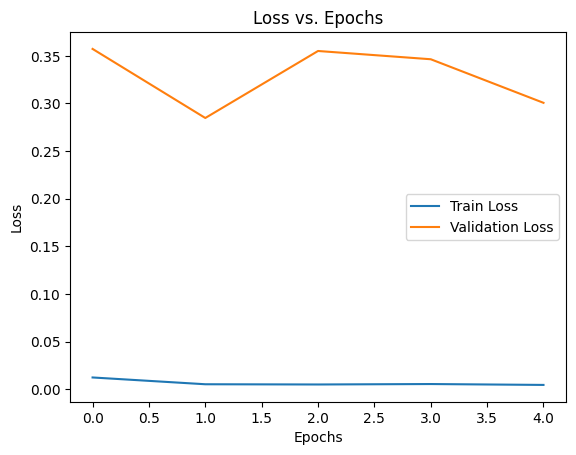

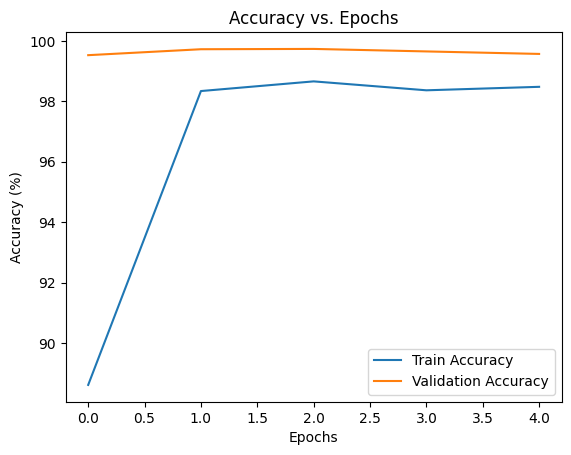

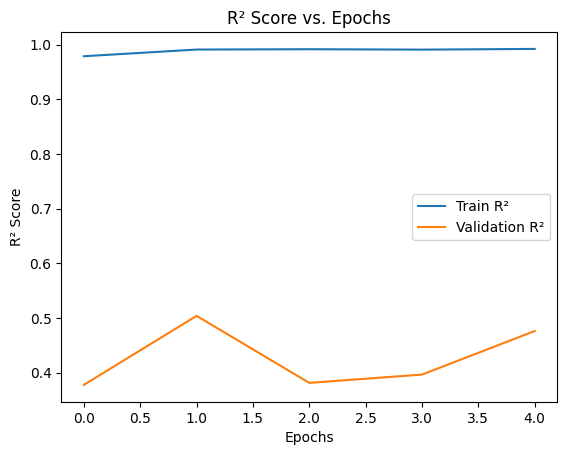

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Dataset Preparation Functions
def add_temporal_features(data, time_col):
    data[time_col] = pd.to_datetime(data[time_col])
    data['Hour'] = data[time_col].dt.hour
    data['Minute'] = data[time_col].dt.minute
    data['Second'] = data[time_col].dt.second
    data['TimeDelta'] = data[time_col].diff().dt.total_seconds().fillna(0)
    return data

def scale_features(data, features_to_scale):
    scalers = {}
    for feature in features_to_scale:
        scaler = MinMaxScaler()
        data[feature] = scaler.fit_transform(data[[feature]])
        scalers[feature] = scaler
    return data, scalers

def prepare_sequences(data, enc_pattern, enc_segment, window_size, prediction_horizon, group_col='SegmentID'):
    data['Pattern'] = np.argmax(data[['Pattern_High Speed', 'Pattern_Slow Movement', 'Pattern_Stationary']].values, axis=1)
    pattern_encoded = enc_pattern.transform(data[['Pattern']])
    segment_encoded = enc_segment.transform(data[[group_col]])
    data['Pattern_Encoded'] = list(pattern_encoded)
    data['SegmentID_Encoded'] = list(segment_encoded)

    sequences = []
    unique_segments = data[group_col].unique()

    for segment in unique_segments:
        segment_data = data[data[group_col] == segment].reset_index(drop=True)
        for start in range(len(segment_data) - window_size - prediction_horizon + 1):
            x_window = segment_data.iloc[start:start+window_size]
            y_window = segment_data.iloc[start+window_size:start+window_size+prediction_horizon]
            sequences.append({
                'X': np.concatenate([
                    x_window[['LAT', 'LON', 'SOG', 'Hour', 'Minute', 'Second', 'TimeDelta']].values,
                    np.stack(x_window['Pattern_Encoded'].values),
                    np.stack(x_window['SegmentID_Encoded'].values)
                ], axis=1),
                'Y': np.concatenate([
                    y_window[['LAT', 'LON', 'SOG', 'Hour', 'Minute', 'Second', 'TimeDelta']].values,
                    np.stack(y_window['Pattern_Encoded'].values),
                    np.stack(y_window['SegmentID_Encoded'].values)
                ], axis=1)
            })
    return sequences

def prepare_data_pipeline(data, window_size, prediction_horizon, test_size=0.2, val_size=0.2):
    data['Pattern'] = np.argmax(data[['Pattern_High Speed', 'Pattern_Slow Movement', 'Pattern_Stationary']].values, axis=1)
    data = add_temporal_features(data, 'BaseDateTime')
    features_to_scale = ['LAT', 'LON', 'SOG', 'TimeDelta']
    data, scalers = scale_features(data, features_to_scale)
    enc_pattern = OneHotEncoder(sparse_output=False)
    enc_segment = OneHotEncoder(sparse_output=False)
    enc_pattern.fit(data[['Pattern']])
    enc_segment.fit(data[['SegmentID']])
    train_data, temp_data = train_test_split(data, test_size=test_size + val_size, random_state=42, shuffle=True)
    val_data, test_data = train_test_split(temp_data, test_size=test_size / (test_size + val_size), random_state=42, shuffle=True)
    train_sequences = prepare_sequences(train_data, enc_pattern, enc_segment, window_size, prediction_horizon)
    val_sequences = prepare_sequences(val_data, enc_pattern, enc_segment, window_size, prediction_horizon)
    test_sequences = prepare_sequences(test_data, enc_pattern, enc_segment, window_size, prediction_horizon)
    return train_sequences, val_sequences, test_sequences, scalers, enc_pattern, enc_segment

# Dataset Class
class SequenceDataset(Dataset):
    def __init__(self, sequences):
        self.encoder_inputs = [torch.tensor(seq['X'], dtype=torch.float32) for seq in sequences]
        self.decoder_inputs = [torch.tensor(seq['Y'], dtype=torch.float32) for seq in sequences]
        self.outputs = [torch.tensor(seq['Y'], dtype=torch.float32) for seq in sequences]

    def __len__(self):
        return len(self.encoder_inputs)

    def __getitem__(self, idx):
        return self.encoder_inputs[idx], self.decoder_inputs[idx], self.outputs[idx]

# Multi-Head Attention
class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        assert hidden_size % num_heads == 0, "Hidden size must be divisible by the number of heads."
        self.depth = hidden_size // num_heads

        self.wq = nn.Linear(hidden_size, hidden_size)
        self.wk = nn.Linear(hidden_size, hidden_size)
        self.wv = nn.Linear(hidden_size, hidden_size)
        self.dense = nn.Linear(hidden_size, hidden_size)

    def split_heads(self, x, batch_size):
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        return x.permute(0, 2, 1, 3)

    def scaled_dot_product_attention(self, q, k, v, mask=None):
        matmul_qk = torch.matmul(q, k.transpose(-2, -1))
        dk = torch.tensor(k.size(-1), dtype=torch.float32)
        scaled_attention_logits = matmul_qk / torch.sqrt(dk)

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        attention_weights = torch.softmax(scaled_attention_logits, dim=-1)
        output = torch.matmul(attention_weights, v)
        return output, attention_weights

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        q = self.wq(query)
        k = self.wk(key)
        v = self.wv(value)
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attn_weights = self.scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = scaled_attention.permute(0, 2, 1, 3).contiguous()
        concat_attention = scaled_attention.view(batch_size, -1, self.hidden_size)
        output = self.dense(concat_attention)
        return output, attn_weights

# Encoder-Decoder Model
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_size, num_heads):
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_size, batch_first=True)
        self.attention = MultiHeadAttention(hidden_size, num_heads)

    def forward(self, x):
        lstm_outputs, (hidden, cell) = self.lstm(x)
        attn_output, _ = self.attention(lstm_outputs, lstm_outputs, lstm_outputs)
        return attn_output, hidden, cell

class Decoder(nn.Module):
    def __init__(self, input_dim, hidden_size, output_dim, num_heads):
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_size, batch_first=True)
        self.attention = MultiHeadAttention(hidden_size, num_heads)
        self.fc = nn.Linear(hidden_size * 2, output_dim)

    def forward(self, x, hidden, cell, encoder_outputs):
        lstm_out, (hidden, cell) = self.lstm(x, (hidden, cell))
        attn_output, attn_weights = self.attention(lstm_out, encoder_outputs, encoder_outputs)
        lstm_out = lstm_out.squeeze(1)
        context = attn_output.squeeze(1)
        concat = torch.cat((lstm_out, context), dim=1)
        outputs = self.fc(concat)
        return outputs, hidden, cell, attn_weights

class Seq2Seq(nn.Module):
    def __init__(self, input_dim, hidden_size, output_dim, predicted_seq_len, num_heads):
        super(Seq2Seq, self).__init__()
        self.encoder = Encoder(input_dim, hidden_size, num_heads)
        self.decoder = Decoder(output_dim, hidden_size, output_dim, num_heads)
        self.predicted_seq_len = predicted_seq_len

    def forward(self, encoder_inputs, decoder_inputs):
        encoder_outputs, hidden, cell = self.encoder(encoder_inputs)
        decoder_outputs = []
        input = decoder_inputs[:, 0, :].unsqueeze(1)
        for t in range(self.predicted_seq_len):
            output, hidden, cell, _ = self.decoder(input, hidden, cell, encoder_outputs)
            decoder_outputs.append(output)
            input = output.unsqueeze(1)
        decoder_outputs = torch.stack(decoder_outputs, dim=1)
        return decoder_outputs

# Metrics and Training Logic
def r2_score_metric(predictions, targets):
    ss_res = torch.sum((targets - predictions) ** 2)
    ss_tot = torch.sum((targets - torch.mean(targets)) ** 2)
    r2_score = 1 - (ss_res / (ss_tot + 1e-10))
    return r2_score.item()

def accuracy_metric(predictions, targets, tolerance=0.1):
    correct = torch.abs(predictions - targets) <= tolerance
    accuracy = correct.sum().item() / torch.numel(targets)
    return accuracy * 100

def train_model(model, train_loader, val_loader, optimizer, criterion, device, model_weights_path, epochs=25):
    model = model.to(device)

    if os.path.exists(model_weights_path):
        print(f"Loading pretrained weights from {model_weights_path}...")
        model.load_state_dict(torch.load(model_weights_path))

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    train_r2_scores, val_r2_scores = [], []

    best_val_r2 = float('-inf')

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_loss, train_acc, train_r2 = 0, 0, 0
        for encoder_inputs, decoder_inputs, outputs in train_loader:
            encoder_inputs, decoder_inputs, outputs = (
                encoder_inputs.to(device),
                decoder_inputs.to(device),
                outputs.to(device),
            )
            optimizer.zero_grad()
            predictions = model(encoder_inputs, decoder_inputs)
            loss = criterion(predictions, outputs)
            loss.backward()
            optimizer.step()

            # Calculate Metrics
            train_loss += loss.item()
            train_acc += accuracy_metric(predictions, outputs)
            train_r2 += r2_score_metric(predictions, outputs)

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        train_r2 /= len(train_loader)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        train_r2_scores.append(train_r2)

        # Validation Phase
        model.eval()
        val_loss, val_acc, val_r2 = 0, 0, 0
        with torch.no_grad():
            for encoder_inputs, decoder_inputs, outputs in val_loader:
                encoder_inputs, decoder_inputs, outputs = (
                    encoder_inputs.to(device),
                    decoder_inputs.to(device),
                    outputs.to(device),
                )
                predictions = model(encoder_inputs, decoder_inputs)
                loss = criterion(predictions, outputs)

                # Calculate Metrics
                val_loss += loss.item()
                val_acc += accuracy_metric(predictions, outputs)
                val_r2 += r2_score_metric(predictions, outputs)

        val_loss /= len(val_loader)
        val_acc /= len(val_loader)
        val_r2 /= len(val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_r2_scores.append(val_r2)

        # Save model if validation R² improves
        if val_r2 > best_val_r2:
            best_val_r2 = val_r2
            torch.save(model.state_dict(), model_weights_path)
            print(f"Model weights saved at {model_weights_path} (Epoch {epoch+1})")

        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, "
              f"Train R²: {train_r2:.4f}, Val R²: {val_r2:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies, train_r2_scores, val_r2_scores

# Hyperparameters
window_size = 5
prediction_horizon = 2
hidden_size = 128
batch_size = 16
epochs = 5
learning_rate = 0.001
num_heads = 8
model_weights_path = "seq2seq_model_best.pth"

# Assume df is your dataset
train_sequences, val_sequences, test_sequences, scalers, enc_pattern, enc_segment = prepare_data_pipeline(df, window_size, prediction_horizon)
train_dataset = SequenceDataset(train_sequences)
val_dataset = SequenceDataset(val_sequences)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Model Initialization
input_dim = train_sequences[0]['X'].shape[1]
output_dim = train_sequences[0]['Y'].shape[1]
predicted_seq_len = prediction_horizon
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Seq2Seq(input_dim, hidden_size, output_dim, predicted_seq_len, num_heads)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Train the Model
train_losses, val_losses, train_accuracies, val_accuracies, train_r2_scores, val_r2_scores = train_model(
    model, train_loader, val_loader, optimizer, criterion, device, model_weights_path, epochs
)

# Plot Metrics
# Plot Loss
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.show()

# Plot Accuracy
plt.figure()
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
# plt.show()

# Plot R² Score
plt.figure()
plt.plot(train_r2_scores, label='Train R²')
plt.plot(val_r2_scores, label='Validation R²')
plt.title('R² Score vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('R² Score')
plt.legend()
# plt.show()


In [ ]:
# Updated Prediction Function
def predict_and_format(model, encoder_input, decoder_input, base_datetime, time_delta, mmsi, segment_id, prediction_horizon, scalers=None, device="cpu"):
    """
    Predict the next sequence and format the output as a DataFrame.
    """
    model.eval()
    encoder_input = torch.tensor(encoder_input, dtype=torch.float32).to(device)
    decoder_input = torch.tensor(decoder_input, dtype=torch.float32).to(device)

    # Predict the sequence
    with torch.no_grad():
        predicted_sequence = model(encoder_input, decoder_input).cpu().numpy()[0]

    # Generate timestamps for predictions
    future_datetimes = [base_datetime + pd.Timedelta(seconds=time_delta * i) for i in range(1, prediction_horizon + 1)]

    # Extract predicted values
    lat_pred = predicted_sequence[:, 0]
    lon_pred = predicted_sequence[:, 1]
    sog_pred = predicted_sequence[:, 2]

    # Decode patterns
    pattern_pred = np.argmax(predicted_sequence[:, 3:6], axis=1)
    pattern_high_speed = (pattern_pred == 0).astype(int)
    pattern_slow_movement = (pattern_pred == 1).astype(int)
    pattern_stationary = (pattern_pred == 2).astype(int)

    # Optional: Inverse transform latitude, longitude, and speed
    if scalers:
        if 'LAT' in scalers:
            lat_pred = scalers['LAT'].inverse_transform(lat_pred.reshape(-1, 1)).flatten()
        if 'LON' in scalers:
            lon_pred = scalers['LON'].inverse_transform(lon_pred.reshape(-1, 1)).flatten()
        if 'SOG' in scalers:
            sog_pred = scalers['SOG'].inverse_transform(sog_pred.reshape(-1, 1)).flatten()

    # Create the output DataFrame
    output_df = pd.DataFrame({
        "BaseDateTime": future_datetimes,
        "LAT": lat_pred,
        "LON": lon_pred,
        "MMSI": [mmsi] * prediction_horizon,
        "Pattern_High Speed": pattern_high_speed,
        "Pattern_Slow Movement": pattern_slow_movement,
        "Pattern_Stationary": pattern_stationary,
        "SOG": sog_pred,
        "SegmentID": [segment_id] * prediction_horizon
    })

    return output_df

def preprocess_and_predict_with_weights(weights_path, data, base_datetime_col, mmsi_col, segment_col, observed_seq_len, predicted_seq_len, time_delta, device="cpu"):
    """
    Preprocess data, include observed data, and perform prediction using a pre-trained model.
    """
    # Separate observed data
    observed_data = data.iloc[:observed_seq_len]
    observed_data['BaseDateTime'] = pd.to_datetime(observed_data[base_datetime_col])
    base_datetime = observed_data['BaseDateTime'].iloc[-1]
    mmsi = data[mmsi_col].iloc[0]
    segment_id = data[segment_col].iloc[0]

    # Prepare encoders
    enc_pattern = OneHotEncoder(sparse_output=False).fit(data[['Pattern']])
    enc_segment = OneHotEncoder(sparse_output=False).fit(data[[segment_col]])

    # Scale features
    scalers = {}
    features_to_scale = ['LAT', 'LON', 'SOG']
    for feature in features_to_scale:
        scaler = MinMaxScaler()
        data[feature] = scaler.fit_transform(data[[feature]])
        scalers[feature] = scaler

    # Prepare inputs
    encoder_input = np.expand_dims(prepare_single_sequence(observed_data, enc_pattern, enc_segment), axis=0)
    decoder_input = np.expand_dims(prepare_decoder_initial_input(observed_data.iloc[-1], enc_pattern, enc_segment, predicted_seq_len), axis=0)

    # Load the model and weights
    input_dim = encoder_input.shape[-1]
    output_dim = decoder_input.shape[-1]
    hidden_size = 128
    num_heads = 8
    model = Seq2Seq(input_dim=input_dim, hidden_size=hidden_size, output_dim=output_dim, predicted_seq_len=predicted_seq_len, num_heads=num_heads).to(device)
    model.load_state_dict(torch.load(weights_path, map_location=device))

    # Perform prediction
    predicted_output = predict_and_format(
        model=model,
        encoder_input=encoder_input,
        decoder_input=decoder_input,
        base_datetime=base_datetime,
        time_delta=time_delta,
        mmsi=mmsi,
        segment_id=segment_id,
        prediction_horizon=predicted_seq_len,
        scalers=scalers,
        device=device
    )

    # Format observed data
    observed_data = observed_data[['BaseDateTime', 'LAT', 'LON', 'SOG', 'Pattern_High Speed', 'Pattern_Slow Movement', 'Pattern_Stationary', 'SegmentID']]
    observed_data['MMSI'] = mmsi

    return observed_data, predicted_output

weights_path = "/content/seq2seq_model_best.pth"
observed_seq_len = 10
predicted_seq_len = 5
time_delta = 10
base_datetime_col = "BaseDateTime"
mmsi_col = "MMSI"
segment_col = "SegmentID"

# Assume df is your dataset
observed_data, predicted_output = preprocess_and_predict_with_weights(
    weights_path=weights_path,
    data=df,
    base_datetime_col=base_datetime_col,
    mmsi_col=mmsi_col,
    segment_col=segment_col,
    observed_seq_len=observed_seq_len,
    predicted_seq_len=predicted_seq_len,
    time_delta=time_delta
)

# Print observed and predicted data
print("Observed Data:")
print(observed_data)

print("\nPredicted Output:")
print(predicted_output)


Observed Data:
         BaseDateTime       LAT       LON       SOG  Pattern_High Speed  \
0 2022-03-31 00:00:17  0.268091  0.834986  0.024390                 0.0   
1 2022-03-31 00:00:27  0.268091  0.834986  0.020392                 0.0   
2 2022-03-31 00:00:37  0.268091  0.834986  0.016393                 0.0   
3 2022-03-31 00:00:47  0.268091  0.834986  0.012395                 0.0   
4 2022-03-31 00:00:57  0.268091  0.834986  0.008397                 0.0   
5 2022-03-31 00:01:07  0.268091  0.834986  0.004398                 0.0   
6 2022-03-31 00:01:17  0.268091  0.834986  0.000400                 0.0   
7 2022-03-31 00:01:27  0.268091  0.834986  0.000000                 0.0   
8 2022-03-31 00:01:37  0.268091  0.834986  0.000000                 0.0   
9 2022-03-31 00:01:47  0.268091  0.834986  0.000000                 0.0   

   Pattern_Slow Movement  Pattern_Stationary  SegmentID     MMSI  
0                    0.0                 1.0          0  1056261  
1                    0.0 

<ipython-input-15-6ea816fc6644>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  observed_data['BaseDateTime'] = pd.to_datetime(observed_data[base_datetime_col])
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
<ipython-input-15-6ea816fc6644>:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which wil